In [2]:
import numpy as np
import pandas as pd
import os
import pickle
from functools import reduce
import anndata as ad
import multiprocessing as mp
import pysam
import warnings
from pathlib import Path
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import linear_sum_assignment
import time
import subprocess
import re
import sys
from scipy import stats
from torch.utils.data import DataLoader
from sklearn.neighbors import KernelDensity
import racplusplus
from collections import Counter

In [3]:
global CACHE_CHROM
global CACHE_SAMFILE
CACHE_CHROM = None
CACHE_SAMFILE = None

def check_pysam_chrom(samFile, chrom=None):
    """Chech if samFile is a file name or pysam object, and if chrom format. 
    """
    global CACHE_CHROM
    global CACHE_SAMFILE

    if CACHE_CHROM is not None:
        if (samFile == CACHE_SAMFILE) and (chrom == CACHE_CHROM):
            return CACHE_SAMFILE, CACHE_CHROM

    if type(samFile) == str or type(samFile) == numpy.str_:
        ftype = samFile.split(".")[-1]
        if ftype != "bam" and ftype != "sam" and ftype != "cram" :
            print("Error: file type need suffix of bam, sam or cram.")
            sys.exit(1)
        if ftype == "cram":
            samFile = pysam.AlignmentFile(samFile, "rc")
        elif ftype == "bam":
            samFile = pysam.AlignmentFile(samFile, "rb")
        else:
            samFile = pysam.AlignmentFile(samFile, "r")

    if chrom is not None:
        if chrom not in samFile.references:
            if chrom.startswith("chr"):
                chrom = chrom.split("chr")[1]
            else:
                chrom = "chr" + chrom
        if chrom not in samFile.references:
            print("Can't find references %s in samFile" %chrom)
            return samFile, None

    CACHE_CHROM = chrom
    CACHE_SAMFILE = samFile
    return samFile, chrom


def load_samfile(samFile, chrom=None):
    """Chech if samFile is a file name or pysam object, and if chrom format.
    """
    print('Warning: The load_samfile() function is recommended to be ' + 
          'replaced by check_pysam_chrom().')

    global CACHE_CHROM
    global CACHE_SAMFILE

    # get from cache
    if CACHE_CHROM is not None:
        if (samFile == CACHE_SAMFILE) and (chrom == CACHE_CHROM):
            return CACHE_SAMFILE, CACHE_CHROM

    # open file
    if type(samFile) == str or type(samFile) == numpy.str_:
        ftype = samFile.split(".")[-1]
        if ftype != "bam" and ftype != "sam" and ftype != "cram" :
            print("Error: file type need suffix of bam, sam or cram.")
            sys.exit(1)
        if ftype == "cram":
            samFile = pysam.AlignmentFile(samFile, "rc")
        elif ftype == "bam":
            samFile = pysam.AlignmentFile(samFile, "rb")
        else:
            samFile = pysam.AlignmentFile(samFile, "r")
    else:
        print("[BRIE2] Error: unknown data type: %s" %samFile)
        print(type(samFile), type(samFile) == numpy.str_)
        sys.exit(1)

    if chrom is not None:
        if chrom not in samFile.references:
            if chrom.startswith("chr"):
                chrom = chrom.split("chr")[1]
            else:
                chrom = "chr" + chrom
        if chrom not in samFile.references:
            print("Can't find references %s in samFile" %chrom)
            return samFile, None

        CACHE_CHROM = chrom
        CACHE_SAMFILE = samFile
        return samFile, chrom
    else:
        CACHE_SAMFILE = samFile
        return samFile


def fetch_reads(samfile, chrom, start, end, rm_duplicate=True, inner_only=True,
                mapq_min=0, trimLen_max=1e6, rlen_min=1,  is_mated=True):
    """To fetch the reads in a given region from a pysam AlignmentFile.

    Args:
        samfile: A Samfile object in pysam.
        chrom: A string of chromosome, e.g., "IV", "chr10".
        start: An integer of the start position for mapped reads.
        end: An integer of the end position for mapped reads.
        rm_duplicate: A bool for only keeping the first one of duplicates.
        inner_only: A bool for only keeping fully region matched reads.
        mapq_min: An integer of the minimum of map quality.
        trimLen_max: An integer of the maximum length of trimmed bases.
        rlen_min: An integer of the minimum of read length.
        is_paired: A bool for mating paired-end reads.

    Returns:
        A dict containing lists of mated reads1 and reads2, and unmated reads1u
        and reads2u, i.e.,
        {'reads1': [r11, r21, ...]
         'reads2': [r12, r22, ...]
         'reads1u': [r*1, r*1, ...]
         'reads2u': [r*2, r*2, ...]}
        reads1 is the 5-end of the fragment, and reads2 is the 3-end of the 
        fragment.

    Raises:
        ValueError: An error occurred when fetching reads.
        AssertionError: An error occurred when fetching reads.
    """
    #part 1. check the input and fetch the reads
    chrom  = str(chrom)
    if chrom in samfile.references:
        pass
    else:
        chrom_parts = chrom.split("chr")
        if len(chrom_parts) <= 1:
            chrom = chrom_parts[0]
        else:
            chrom = chrom_parts[1]

    try:
        reads = samfile.fetch(chrom, start, end)
    except ValueError:
        reads = []
        print("Cannot fetch reads in region: %s:%d-%d" %(chrom, start, end))
    except AssertionError:
        reads = []
        print("AssertionError in region: %s:%d-%d" %(chrom, start, end))
        print(" - Check that your BAM file is indexed!")

    #part 2. get reads and filter some of them
    qname1, qname2 = [], []
    reads1, reads2 = [], []
    r_prev = None
    for r in reads:
        # filter 4: only keep the first one of duplicates
        if (rm_duplicate and r_prev is not None and r_prev.qname == r.qname and 
            r_prev.positions == r.positions): r_prev = r; continue
        r_prev = r
        # filter 1: only particially mapped to the regions
        if inner_only == True and (r.pos is None or r.pos < start or 
                                   r.aend is None or r.aend > end): continue
        # filter 2: too low map quality
        if r.mapq < mapq_min: continue
        # filter 3: too long trimmed bases
        if r.rlen - len(r.positions) > trimLen_max: continue
        # filter 5: too short mapped length
        if len(r.positions) < rlen_min: continue
        
        if r.is_read2:
            reads2.append(r)
            qname2.append(r.qname)
        else:
            reads1.append(r)
            qname1.append(r.qname)

    #part 2.1 chech the mate reads' query
    FLAG = True
    if len(qname1) > 0:
        for i in range(len(qname1)-1):
            if qname1[i][-1] != qname1[i+1][-1]:
                FLAG = False
                break
    if FLAG and len(qname2) > 0:
        for i in range(len(qname1)-1):
            if qname1[i][-1] != qname1[i+1][-1]:
                FLAG = False
                break

    if FLAG:
        for i in range(len(qname1)):
            qname1[i] = qname1[i][:-1]
        for i in range(len(qname2)):
            qname2[i] = qname2[i][:-1]


    # part 3. mate the reads
    rv_reads1, rv_reads2 = [], []
    rv_reads1u, rv_reads2u = [], []
    if is_mated == True:
        idx1 = sorted(range(len(qname1)), key=qname1.__getitem__)
        idx2 = sorted(range(len(qname2)), key=qname2.__getitem__)

        i1, i2 = 0, 0
        while i1 < len(idx1) and i2 < len(idx2):
            if qname1[idx1[i1]] == qname2[idx2[i2]]:
                rv_reads1.append(reads1[idx1[i1]])
                rv_reads2.append(reads2[idx2[i2]])
                i1, i2 = i1 + 1, i2 + 1
            elif qname1[idx1[i1]] < qname2[idx2[i2]]:
                rv_reads1u.append(reads1[idx1[i1]])
                i1 += 1
            elif qname1[idx1[i1]] > qname2[idx2[i2]]:
                rv_reads2u.append(reads2[idx2[i2]])
                i2 += 1
        for i in range(i1, len(idx1)):
            rv_reads1u.append(reads1[idx1[i]])
        for i in range(i2, len(idx2)):
            rv_reads2u.append(reads2[idx2[i]])
    else:
        rv_reads1u, rv_reads2u = reads1, reads2

    # part 4. return reads
    RV = {}
    RV["reads1"] = rv_reads1
    RV["reads2"] = rv_reads2
    RV["reads1u"] = rv_reads1u
    RV["reads2u"] = rv_reads2u
    return RV

In [13]:
chromosizedf=pd.read_csv('/mnt/ruiyanhou/nfs_share2/annotation/hg38.chrom.sizes',delimiter='\t',header=None,index_col=0)
chromosizedf

,1
0,
chr1,248956422
chr2,242193529
chr3,198295559
chr4,190214555
chr5,181538259
...,...
chrUn_GL000214v1,137718
chrUn_KI270742v1,186739
chrUn_GL000216v2,176608


In [14]:
chromosizedf=chromosizedf.head(n=25)
chromosizedf

,1
0,
chr1,248956422
chr2,242193529
chr3,198295559
chr4,190214555
chr5,181538259
chr6,170805979
chr7,159345973
chr8,145138636
chr9,138394717


In [15]:
bamFile='/mnt/ruiyanhou/nfs_share2/three_primer/PBMC/run_STAR/STAR_result/PBMC_866_for_scTail_rerun_change_filtered_by_GX.bam'

In [20]:
transcriptdf=pd.read_csv('/mnt/ruiyanhou/nfs_share2/annotation/annotation_from_Gencode/one_transcript_gene.bed',delimiter='\t',header=None)
transcriptdf

,0,1,2,3,4,5
0,chr1,11868,14409,ENST00000456328.2_ENSG00000290825.1,.,+
1,chr1,12009,13670,ENST00000450305.2_ENSG00000223972.6,.,+
2,chr1,30365,30503,ENST00000607096.1_ENSG00000284332.1,.,+
3,chr1,52472,53312,ENST00000606857.1_ENSG00000268020.3,.,+
4,chr1,57597,64116,ENST00000642116.1_ENSG00000290826.1,.,+
...,...,...,...,...,...,...
38675,chrY,57015104,57016096,ENST00000711258.1_ENSG00000292364.1,.,-
38676,chrY,57165511,57165845,ENST00000711266.1_ENSG00000292367.1,.,-
38677,chrY,57171889,57172769,ENST00000711267.1_ENSG00000292368.1,.,-
38678,chrY,57201142,57203357,ENST00000711269.1_ENSG00000292370.1,.,-


In [22]:
transcriptdf['gene_id']=transcriptdf[3].str.split('_',expand=True)[1]
transcriptdf

,0,1,2,3,4,5,gene_id
0,chr1,11868,14409,ENST00000456328.2_ENSG00000290825.1,.,+,ENSG00000290825.1
1,chr1,12009,13670,ENST00000450305.2_ENSG00000223972.6,.,+,ENSG00000223972.6
2,chr1,30365,30503,ENST00000607096.1_ENSG00000284332.1,.,+,ENSG00000284332.1
3,chr1,52472,53312,ENST00000606857.1_ENSG00000268020.3,.,+,ENSG00000268020.3
4,chr1,57597,64116,ENST00000642116.1_ENSG00000290826.1,.,+,ENSG00000290826.1
...,...,...,...,...,...,...,...
38675,chrY,57015104,57016096,ENST00000711258.1_ENSG00000292364.1,.,-,ENSG00000292364.1
38676,chrY,57165511,57165845,ENST00000711266.1_ENSG00000292367.1,.,-,ENSG00000292367.1
38677,chrY,57171889,57172769,ENST00000711267.1_ENSG00000292368.1,.,-,ENSG00000292368.1
38678,chrY,57201142,57203357,ENST00000711269.1_ENSG00000292370.1,.,-,ENSG00000292370.1


In [29]:
fragmentsizels=[]

for index, row in transcriptdf.iterrows():

    samFile, _chrom = check_pysam_chrom(bamFile, row[0])
    reads = fetch_reads(samFile, _chrom,  row[1], row[2],  trimLen_max=100)


    
    reads1_paired=reads['reads2']
    reads2_paired=reads['reads1']

    reads1_paired=[r for r in reads1_paired if r.get_tag('GX')==row['gene_id']]
    reads2_paired=[r for r in reads2_paired if r.get_tag('GX')==row['gene_id']]

    
    

    if row[5]=='+':
        reads1_paired=[r for r in reads1_paired if r.is_reverse==True]
        reads2_paired=[r for r in reads2_paired if r.is_reverse==False]
        
        reads1_pas=[r.reference_end for r in reads1_paired]
        reads2_pas=[r.reference_end for r in reads2_paired]
        fragment_size=[reads1_pas[i]-reads2_pas[i] for i in range(0,len(reads1_pas))]
    
        
    elif row[5]=='-':
        reads1_paired=[r for r in reads1_paired if r.is_reverse==False]
        reads2_paired=[r for r in reads2_paired if r.is_reverse==True]

        reads1_pas=[r.reference_start for r in reads1_paired]
        reads2_pas=[r.reference_start for r in reads2_paired]
        fragment_size=[reads2_pas[i]-reads1_pas[i] for i in range(0,len(reads1_pas))]

    fragmentsizels.append(fragment_size)



In [30]:
fragmentsizels

[[186],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [0,
  154,
  122,
  34,
  162,
  173,
  141,
  97,
  211,
  170,
  43,
  168,
  101,
  135,
  95,
  207,
  208,
  49,
  49,
  171,
  166,
  182,
  137,
  176,
  152,
  95,
  167,
  153,
  96,
  45,
  137,
  161,
  191,
  186,
  103,
  175,
  199,
  179,
  173,
  171,
  146,
  188,
  168,
  126,
  114,
  96,
  161,
  154,
  177,
  179,
  103,
  135,
  190,
  112,
  151,
  53,
  145,
  103,
  168,
  163,
  146,
  170,
  190,
  146,
  165,
  141,
  109,
  204,
  76,
  101,
  174,
  130,
  161,
  131,
  163,
  156,
  191,
  173,
  153,
  186,
  194,
  157,
  165,
  155,
  96,
  117,
  105,
  191,
  107,
  207,
  21,
  108,
  124,
  106,
  149,
  170,
  90,
  98,
  169,
  197,
  140,
  158,
  129,
  40,
  184,
  80,
  178,
  201,
  98,
  184,
  167,
  118,
  119,
  102,
  11,
  106,
  186,
  103,
  186,
  122,
  57,
  137,
  45,
  188,
  189,
  122,
  79,
  111,
  174,
  183],
 [148,
  121,
  131,
  200,
  184,
  96,
  98,

In [31]:
fragment_flattenls=[j for i in fragmentsizels for j in i]
fragment_flattenls

[186,
 0,
 154,
 122,
 34,
 162,
 173,
 141,
 97,
 211,
 170,
 43,
 168,
 101,
 135,
 95,
 207,
 208,
 49,
 49,
 171,
 166,
 182,
 137,
 176,
 152,
 95,
 167,
 153,
 96,
 45,
 137,
 161,
 191,
 186,
 103,
 175,
 199,
 179,
 173,
 171,
 146,
 188,
 168,
 126,
 114,
 96,
 161,
 154,
 177,
 179,
 103,
 135,
 190,
 112,
 151,
 53,
 145,
 103,
 168,
 163,
 146,
 170,
 190,
 146,
 165,
 141,
 109,
 204,
 76,
 101,
 174,
 130,
 161,
 131,
 163,
 156,
 191,
 173,
 153,
 186,
 194,
 157,
 165,
 155,
 96,
 117,
 105,
 191,
 107,
 207,
 21,
 108,
 124,
 106,
 149,
 170,
 90,
 98,
 169,
 197,
 140,
 158,
 129,
 40,
 184,
 80,
 178,
 201,
 98,
 184,
 167,
 118,
 119,
 102,
 11,
 106,
 186,
 103,
 186,
 122,
 57,
 137,
 45,
 188,
 189,
 122,
 79,
 111,
 174,
 183,
 148,
 121,
 131,
 200,
 184,
 96,
 98,
 251,
 234,
 210,
 81,
 132,
 160,
 8,
 174,
 78,
 14,
 136,
 139,
 62,
 168,
 353,
 29,
 170,
 177,
 167,
 92,
 258,
 138,
 169,
 159,
 188,
 59,
 119,
 257,
 126,
 191,
 75,
 48,
 146,
 196,
 34,
 

In [32]:
distancenp=np.array(fragment_flattenls).reshape([-1,1])
distancenp

array([[186],
       [  0],
       [154],
       ...,
       [ 54],
       [ 21],
       [ 81]])

In [40]:
distancenp.shape

(1025983, 1)

In [34]:
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(distancenp)

In [35]:
kde

KernelDensity(bandwidth=1)

In [45]:
x_range = np.linspace(0,2000, num=2000)
log_density = kde.score_samples(x_range.reshape(-1,1))

In [46]:
fragmentLen=np.argmax(log_density)


In [47]:
fragmentLen

86

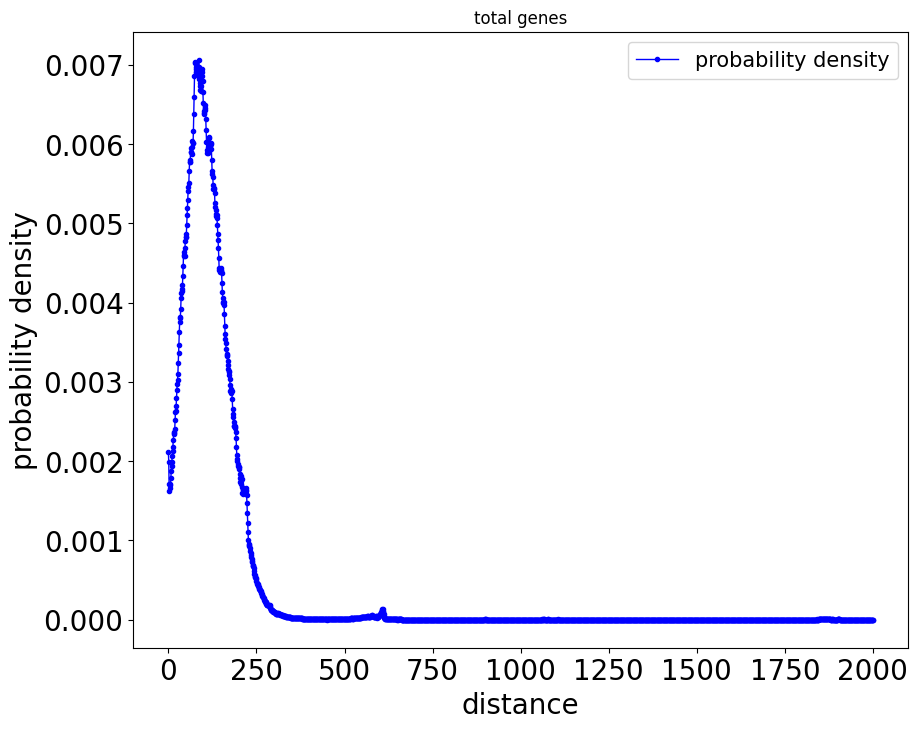

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(x_range[:, np.newaxis], np.exp(log_density), marker='.', linewidth=1, c="b", label='probability density')
plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小      
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('distance', font)
plt.ylabel('probability density', font)
plt.title('total genes')
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

In [106]:
positive_genedf=pd.read_csv('/mnt/ruiyanhou/nfs_share2/three_primer/PBMC/run_scTail/PBMC866_final_extract_reads/count/positive_peak_mapped_gene.tsv',delimiter='\t',header=None)
positive_genedf.columns=['cluster_chr','cluster_start','cluster_end','cluster_id','cluster_score','strand','gene_chr','gene_start','gene_end','gene_id','gene_score','gene_strand']
positive_genedf

,cluster_chr,cluster_start,cluster_end,cluster_id,cluster_score,strand,gene_chr,gene_start,gene_end,gene_id,gene_score,gene_strand
0,chr1,630405,630457,chr1_+_630405_630457,0,+,chr1,629639,630683,ENSG00000225630.1,.,+
1,chr1,630405,630457,chr1_+_630405_630457,0,+,chr1,586070,827796,ENSG00000230021.10,.,-
2,chr1,854366,854403,chr1_+_854366_854403,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
3,chr1,857142,857218,chr1_+_857142_857218,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
4,chr1,1014485,1014540,chr1_+_1014485_1014540,0,+,chr1,1001137,1014540,ENSG00000187608.10,.,+
...,...,...,...,...,...,...,...,...,...,...,...,...
23308,chrY,20593125,20593152,chrY_+_20593125_20593152,0,+,chrY,20575775,20593154,ENSG00000198692.10,.,+
23309,chrY,11161849,11161886,chrY_-_11161849_11161886,0,-,chrY,11153796,11215032,ENSG00000291032.1,.,-
23310,chrY,13234578,13234614,chrY_-_13234578_13234614,0,-,chrY,13234576,13480673,ENSG00000183878.16,.,-
23311,chrY,19705418,19705440,chrY_-_19705418_19705440,0,-,chrY,19703864,19744939,ENSG00000012817.16,.,-


In [140]:
positive_genedf['cluster_id']=positive_genedf['cluster_id']+'*'+positive_genedf['gene_id']
positive_genedf

,cluster_chr,cluster_start,cluster_end,cluster_id,cluster_score,strand,gene_chr,gene_start,gene_end,gene_id,gene_score,gene_strand
0,chr1,630405,630457,chr1_+_630405_630457*ENSG00000225630.1,0,+,chr1,629639,630683,ENSG00000225630.1,.,+
1,chr1,630405,630457,chr1_+_630405_630457*ENSG00000230021.10,0,+,chr1,586070,827796,ENSG00000230021.10,.,-
2,chr1,854366,854403,chr1_+_854366_854403*ENSG00000228794.12,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
3,chr1,857142,857218,chr1_+_857142_857218*ENSG00000228794.12,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
4,chr1,1014485,1014540,chr1_+_1014485_1014540*ENSG00000187608.10,0,+,chr1,1001137,1014540,ENSG00000187608.10,.,+
...,...,...,...,...,...,...,...,...,...,...,...,...
23308,chrY,20593125,20593152,chrY_+_20593125_20593152*ENSG00000198692.10,0,+,chrY,20575775,20593154,ENSG00000198692.10,.,+
23309,chrY,11161849,11161886,chrY_-_11161849_11161886*ENSG00000291032.1,0,-,chrY,11153796,11215032,ENSG00000291032.1,.,-
23310,chrY,13234578,13234614,chrY_-_13234578_13234614*ENSG00000183878.16,0,-,chrY,13234576,13480673,ENSG00000183878.16,.,-
23311,chrY,19705418,19705440,chrY_-_19705418_19705440*ENSG00000012817.16,0,-,chrY,19703864,19744939,ENSG00000012817.16,.,-


In [162]:
filtered_positive_genedf=positive_genedf[(positive_genedf['strand']==positive_genedf['gene_strand'])&(positive_genedf['cluster_chr']==positive_genedf['gene_chr'])]
filtered_positive_genedf

,cluster_chr,cluster_start,cluster_end,cluster_id,cluster_score,strand,gene_chr,gene_start,gene_end,gene_id,gene_score,gene_strand
0,chr1,630405,630457,chr1_+_630405_630457*ENSG00000225630.1,0,+,chr1,629639,630683,ENSG00000225630.1,.,+
2,chr1,854366,854403,chr1_+_854366_854403*ENSG00000228794.12,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
3,chr1,857142,857218,chr1_+_857142_857218*ENSG00000228794.12,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
4,chr1,1014485,1014540,chr1_+_1014485_1014540*ENSG00000187608.10,0,+,chr1,1001137,1014540,ENSG00000187608.10,.,+
6,chr1,1311631,1311677,chr1_+_1311631_1311677*ENSG00000169972.13,0,+,chr1,1308596,1311677,ENSG00000169972.13,.,+
...,...,...,...,...,...,...,...,...,...,...,...,...
23308,chrY,20593125,20593152,chrY_+_20593125_20593152*ENSG00000198692.10,0,+,chrY,20575775,20593154,ENSG00000198692.10,.,+
23309,chrY,11161849,11161886,chrY_-_11161849_11161886*ENSG00000291032.1,0,-,chrY,11153796,11215032,ENSG00000291032.1,.,-
23310,chrY,13234578,13234614,chrY_-_13234578_13234614*ENSG00000183878.16,0,-,chrY,13234576,13480673,ENSG00000183878.16,.,-
23311,chrY,19705418,19705440,chrY_-_19705418_19705440*ENSG00000012817.16,0,-,chrY,19703864,19744939,ENSG00000012817.16,.,-


In [174]:
positive_gene_example=filtered_positive_genedf.head(n=100)
positive_gene_example

,cluster_chr,cluster_start,cluster_end,cluster_id,cluster_score,strand,gene_chr,gene_start,gene_end,gene_id,gene_score,gene_strand
0,chr1,630405,630457,chr1_+_630405_630457*ENSG00000225630.1,0,+,chr1,629639,630683,ENSG00000225630.1,.,+
2,chr1,854366,854403,chr1_+_854366_854403*ENSG00000228794.12,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
3,chr1,857142,857218,chr1_+_857142_857218*ENSG00000228794.12,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
4,chr1,1014485,1014540,chr1_+_1014485_1014540*ENSG00000187608.10,0,+,chr1,1001137,1014540,ENSG00000187608.10,.,+
6,chr1,1311631,1311677,chr1_+_1311631_1311677*ENSG00000169972.13,0,+,chr1,1308596,1311677,ENSG00000169972.13,.,+
...,...,...,...,...,...,...,...,...,...,...,...,...
116,chr1,19259432,19259447,chr1_+_19259432_19259447*ENSG00000053372.5,0,+,chr1,19251804,19260128,ENSG00000053372.5,.,+
117,chr1,19260076,19260128,chr1_+_19260076_19260128*ENSG00000053372.5,0,+,chr1,19251804,19260128,ENSG00000053372.5,.,+
118,chr1,19329248,19329300,chr1_+_19329248_19329300*ENSG00000040487.13,0,+,chr1,19312325,19329300,ENSG00000040487.13,.,+
119,chr1,19626569,19626634,chr1_+_19626569_19626634*ENSG00000158747.15,0,+,chr1,19596978,19658456,ENSG00000158747.15,.,+


In [175]:
import warnings
warnings.filterwarnings("ignore")

In [176]:
%%time
read_info_ls=[]
allclusterls=[]
for index, row in positive_gene_example.iterrows():

    samFile, _chrom = check_pysam_chrom(bamFile, row['cluster_chr'])
    reads = fetch_reads(samFile, _chrom,  row['gene_start'], row['gene_end'],  trimLen_max=100)

    
    reads2_paired=reads['reads1']
    reads2_unique=reads['reads1u']

    reads2_paired=[r for r in reads2_paired if r.get_tag('GX')==row['gene_id']]
    reads2_unique=[r for r in reads2_unique if r.get_tag('GX')==row['gene_id']]
    


    if row[5]=='+':
        reads2_paired=[r for r in reads2_paired if (r.reference_end+fragmentLen>row['cluster_start'])&(r.reference_end+fragmentLen<row['cluster_end'])]
        reads2_unique=[r for r in reads2_unique if (r.reference_end+fragmentLen>row['cluster_start'])&(r.reference_end+fragmentLen<row['cluster_end'])]
        
        reads2=reads2_paired+reads2_unique
        reads_info=[r.get_tag('CB') for r in reads2]
            
    elif row[5]=='-':
        reads2_paired=[r for r in reads2_paired if (r.reference_start-fragmentLen>row['cluster_start'])&(r.reference_start-fragmentLen<row['cluster_end'])]
        reads2_unique=[r for r in reads2_unique if (r.reference_start-fragmentLen>row['cluster_start'])&(r.reference_start-fragmentLen<row['cluster_end'])]

        reads2=reads2_paired+reads2_unique
        reads_info=[r.get_tag('CB') for r in reads2]


    cellID,counts=np.unique(reads_info,return_counts=True)
    clusterdf=pd.DataFrame({'cell_id':cellID,row['cluster_id']:counts})
    clusterdf.set_index('cell_id',inplace=True)
    

    #print(reads_info)
    read_info_ls.append(reads_info)
    allclusterls.append(clusterdf)
    

    

CPU times: user 6.9 s, sys: 51.9 ms, total: 6.95 s
Wall time: 6.96 s


In [177]:
unique_cellbarcode_set=set([j for i in read_info_ls for j in i])
unique_cellbarcode_set

{'CGCGGTACATTTCAGG',
 'ACAGCCGAGTCGCCGT',
 'ATGGGAGCAGCTGCAC',
 'TACGGGCAGTCGTTTG',
 'CACACAAAGAAGGACA',
 'ACAGCTAGTACGAAAT',
 'TCGCGAGAGCAATCTC',
 'CCACTACAGCAACGGT',
 'CCTTTCTCAGTCCTTC',
 'CGATGTAGTCATGCCG',
 'CACAAACAGCACCGTC',
 'CCGTGGAGTAGAGTGC',
 'TTCGGTCGTGAGCGAT',
 'GTTAAGCCACGTGAGA',
 'GAAACTCTCGGCTTGG',
 'AGGCCGTTCAGTTAGC',
 'CCTACCACACTGTTAG',
 'ATCTGCCCACACGCTG',
 'TGCCCTACAGCCTATA',
 'TGGACGCTCAGTCAGT',
 'CACACAAGTCGGGTCT',
 'CTACGTCGTAGTACCT',
 'AGCGTATTCTAGAGTC',
 'GTGTTAGCATGCAATC',
 'TCAGCAAAGCGTAATA',
 'GAACGGAAGATCTGCT',
 'TATTACCGTCTTCAAG',
 'AAACCTGTCCAGAAGG',
 'TCAGCTCCATATGCTG',
 'CATGACATCATTGCGA',
 'ACCGTAATCAGCATGT',
 'GCACATATCAACCAAC',
 'CTCGAGGGTCTTGATG',
 'CGGCTAGGTGCAACTT',
 'GACCAATTCAAGGCTT',
 'CATCGGGTCCCATTAT',
 'GACTGCGAGTCAATAG',
 'TCAGCTCCAAGGACTG',
 'CAGGTGCGTTCTGTTT',
 'ACGAGCCAGCCGTCGT',
 'TGTATTCAGTTCGATC',
 'TCCCGATGTTCGTCTC',
 'GACAGAGTCAGAAATG',
 'ACGGGCTCAAGTTGTC',
 'TAGCCGGTCTCGAGTA',
 'AAAGCAAGTGAGTATA',
 'GGGAGATGTGCGGTAA',
 'AGCTCCTGTGA

In [178]:
len(unique_cellbarcodels)

9296

In [179]:
finaldf=pd.DataFrame(index=list(unique_cellbarcode_set))
finaldf

""
CGCGGTACATTTCAGG
ACAGCCGAGTCGCCGT
ATGGGAGCAGCTGCAC
TACGGGCAGTCGTTTG
CACACAAAGAAGGACA
...
GCGACCAGTTGACGTT
ATTCTACGTTATCCGA
TTTGTCAGTGCTTCTC
AACTGGTTCTCTAAGG


In [180]:
for onedf in allclusterls:
    cluster_column=onedf.columns[0]
    print(cluster_column)
    finaldf[cluster_column]=finaldf.index.map(onedf[cluster_column])

chr1_+_630405_630457*ENSG00000225630.1
chr1_+_854366_854403*ENSG00000228794.12
chr1_+_857142_857218*ENSG00000228794.12
chr1_+_1014485_1014540*ENSG00000187608.10
chr1_+_1311631_1311677*ENSG00000169972.13
chr1_+_1328838_1328896*ENSG00000224051.7
chr1_+_1401984_1402043*ENSG00000224870.9
chr1_+_1496165_1496203*ENSG00000160072.20
chr1_+_1534639_1534685*ENSG00000197785.14
chr1_+_1617281_1617321*ENSG00000197530.13
chr1_+_1630552_1630605*ENSG00000197530.13
chr1_+_2185347_2185393*ENSG00000067606.17
chr1_+_2310066_2310114*ENSG00000157933.11
chr1_+_2310178_2310209*ENSG00000157933.11
chr1_+_2403192_2403221*ENSG00000157916.20
chr1_+_2403290_2403302*ENSG00000157916.20
chr1_+_2403722_2403759*ENSG00000157916.20
chr1_+_2405377_2405441*ENSG00000157916.20
chr1_+_2505495_2505530*ENSG00000149527.18
chr1_+_2547414_2547468*ENSG00000272449.3
chr1_+_2563701_2563749*ENSG00000157873.18
chr1_+_2563799_2563829*ENSG00000157873.18
chr1_+_2584490_2584531*ENSG00000228037.1
chr1_+_2591426_2591468*ENSG00000157870.17
chr

In [181]:
finaldf

,chr1_+_630405_630457*ENSG00000225630.1,chr1_+_854366_854403*ENSG00000228794.12,chr1_+_857142_857218*ENSG00000228794.12,chr1_+_1014485_1014540*ENSG00000187608.10,chr1_+_1311631_1311677*ENSG00000169972.13,chr1_+_1328838_1328896*ENSG00000224051.7,chr1_+_1401984_1402043*ENSG00000224870.9,chr1_+_1496165_1496203*ENSG00000160072.20,chr1_+_1534639_1534685*ENSG00000197785.14,chr1_+_1617281_1617321*ENSG00000197530.13,...,chr1_+_16972927_16972957*ENSG00000058453.17,chr1_+_17363947_17364004*ENSG00000159339.13,chr1_+_17401671_17401697*ENSG00000276747.1,chr1_+_19240615_19240702*ENSG00000230424.3,chr1_+_19259242_19259263*ENSG00000053372.5,chr1_+_19259432_19259447*ENSG00000053372.5,chr1_+_19260076_19260128*ENSG00000053372.5,chr1_+_19329248_19329300*ENSG00000040487.13,chr1_+_19626569_19626634*ENSG00000158747.15,chr1_+_19626569_19626634*ENSG00000270136.6
CGCGGTACATTTCAGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACAGCCGAGTCGCCGT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATGGGAGCAGCTGCAC,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TACGGGCAGTCGTTTG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CACACAAAGAAGGACA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCGACCAGTTGACGTT,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATTCTACGTTATCCGA,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTCAGTGCTTCTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACTGGTTCTCTAAGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
finaldf.fillna(0,inplace=True)
finaldf

,chr1_+_630405_630457*ENSG00000225630.1,chr1_+_854366_854403*ENSG00000228794.12,chr1_+_857142_857218*ENSG00000228794.12,chr1_+_1014485_1014540*ENSG00000187608.10,chr1_+_1311631_1311677*ENSG00000169972.13,chr1_+_1328838_1328896*ENSG00000224051.7,chr1_+_1401984_1402043*ENSG00000224870.9,chr1_+_1496165_1496203*ENSG00000160072.20,chr1_+_1534639_1534685*ENSG00000197785.14,chr1_+_1617281_1617321*ENSG00000197530.13,...,chr1_+_16972927_16972957*ENSG00000058453.17,chr1_+_17363947_17364004*ENSG00000159339.13,chr1_+_17401671_17401697*ENSG00000276747.1,chr1_+_19240615_19240702*ENSG00000230424.3,chr1_+_19259242_19259263*ENSG00000053372.5,chr1_+_19259432_19259447*ENSG00000053372.5,chr1_+_19260076_19260128*ENSG00000053372.5,chr1_+_19329248_19329300*ENSG00000040487.13,chr1_+_19626569_19626634*ENSG00000158747.15,chr1_+_19626569_19626634*ENSG00000270136.6
CGCGGTACATTTCAGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACAGCCGAGTCGCCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATGGGAGCAGCTGCAC,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TACGGGCAGTCGTTTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CACACAAAGAAGGACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCGACCAGTTGACGTT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATTCTACGTTATCCGA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCAGTGCTTCTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACTGGTTCTCTAAGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
finaldf=finaldf.loc[:, (finaldf != 0).any(axis=0)]
finaldf

,chr1_+_630405_630457*ENSG00000225630.1,chr1_+_854366_854403*ENSG00000228794.12,chr1_+_857142_857218*ENSG00000228794.12,chr1_+_1014485_1014540*ENSG00000187608.10,chr1_+_1311631_1311677*ENSG00000169972.13,chr1_+_1328838_1328896*ENSG00000224051.7,chr1_+_1401984_1402043*ENSG00000224870.9,chr1_+_1496165_1496203*ENSG00000160072.20,chr1_+_1534639_1534685*ENSG00000197785.14,chr1_+_1617281_1617321*ENSG00000197530.13,...,chr1_+_16459173_16459222*ENSG00000157191.20,chr1_+_16460036_16460078*ENSG00000157191.20,chr1_+_16972927_16972957*ENSG00000058453.17,chr1_+_17363947_17364004*ENSG00000159339.13,chr1_+_17401671_17401697*ENSG00000276747.1,chr1_+_19240615_19240702*ENSG00000230424.3,chr1_+_19259242_19259263*ENSG00000053372.5,chr1_+_19259432_19259447*ENSG00000053372.5,chr1_+_19260076_19260128*ENSG00000053372.5,chr1_+_19329248_19329300*ENSG00000040487.13
CGCGGTACATTTCAGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACAGCCGAGTCGCCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATGGGAGCAGCTGCAC,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TACGGGCAGTCGTTTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
CACACAAAGAAGGACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCGACCAGTTGACGTT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATTCTACGTTATCCGA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCAGTGCTTCTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACTGGTTCTCTAAGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
adata=ad.AnnData(finaldf)

In [185]:
adata

AnnData object with n_obs × n_vars = 9762 × 97

In [186]:
vardf=pd.DataFrame(adata.var.copy())
vardf


""
chr1_+_630405_630457*ENSG00000225630.1
chr1_+_854366_854403*ENSG00000228794.12
chr1_+_857142_857218*ENSG00000228794.12
chr1_+_1014485_1014540*ENSG00000187608.10
chr1_+_1311631_1311677*ENSG00000169972.13
...
chr1_+_19240615_19240702*ENSG00000230424.3
chr1_+_19259242_19259263*ENSG00000053372.5
chr1_+_19259432_19259447*ENSG00000053372.5
chr1_+_19260076_19260128*ENSG00000053372.5


In [187]:
vardf.reset_index(inplace=True)


In [188]:
vardf.columns=['cluster_id']
vardf

,cluster_id
0,chr1_+_630405_630457*ENSG00000225630.1
1,chr1_+_854366_854403*ENSG00000228794.12
2,chr1_+_857142_857218*ENSG00000228794.12
3,chr1_+_1014485_1014540*ENSG00000187608.10
4,chr1_+_1311631_1311677*ENSG00000169972.13
...,...
92,chr1_+_19240615_19240702*ENSG00000230424.3
93,chr1_+_19259242_19259263*ENSG00000053372.5
94,chr1_+_19259432_19259447*ENSG00000053372.5
95,chr1_+_19260076_19260128*ENSG00000053372.5


In [189]:
vardf=vardf.merge(positive_gene_example,on='cluster_id')
vardf



,cluster_id,cluster_chr,cluster_start,cluster_end,cluster_score,strand,gene_chr,gene_start,gene_end,gene_id,gene_score,gene_strand
0,chr1_+_630405_630457*ENSG00000225630.1,chr1,630405,630457,0,+,chr1,629639,630683,ENSG00000225630.1,.,+
1,chr1_+_854366_854403*ENSG00000228794.12,chr1,854366,854403,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
2,chr1_+_857142_857218*ENSG00000228794.12,chr1,857142,857218,0,+,chr1,825137,859446,ENSG00000228794.12,.,+
3,chr1_+_1014485_1014540*ENSG00000187608.10,chr1,1014485,1014540,0,+,chr1,1001137,1014540,ENSG00000187608.10,.,+
4,chr1_+_1311631_1311677*ENSG00000169972.13,chr1,1311631,1311677,0,+,chr1,1308596,1311677,ENSG00000169972.13,.,+
...,...,...,...,...,...,...,...,...,...,...,...,...
92,chr1_+_19240615_19240702*ENSG00000230424.3,chr1,19240615,19240702,0,+,chr1,19210347,19240709,ENSG00000230424.3,.,+
93,chr1_+_19259242_19259263*ENSG00000053372.5,chr1,19259242,19259263,0,+,chr1,19251804,19260128,ENSG00000053372.5,.,+
94,chr1_+_19259432_19259447*ENSG00000053372.5,chr1,19259432,19259447,0,+,chr1,19251804,19260128,ENSG00000053372.5,.,+
95,chr1_+_19260076_19260128*ENSG00000053372.5,chr1,19260076,19260128,0,+,chr1,19251804,19260128,ENSG00000053372.5,.,+


In [192]:
vardf.set_index('cluster_id',inplace=True,drop=True)
vardf

,cluster_chr,cluster_start,cluster_end,cluster_score,strand,gene_chr,gene_start,gene_end,gene_id,gene_score,gene_strand,test
cluster_id,,,,,,,,,,,,
chr1_+_630405_630457*ENSG00000225630.1,chr1,630405,630457,0,+,chr1,629639,630683,ENSG00000225630.1,.,+,chr1_+_630405_630457
chr1_+_854366_854403*ENSG00000228794.12,chr1,854366,854403,0,+,chr1,825137,859446,ENSG00000228794.12,.,+,chr1_+_854366_854403
chr1_+_857142_857218*ENSG00000228794.12,chr1,857142,857218,0,+,chr1,825137,859446,ENSG00000228794.12,.,+,chr1_+_857142_857218
chr1_+_1014485_1014540*ENSG00000187608.10,chr1,1014485,1014540,0,+,chr1,1001137,1014540,ENSG00000187608.10,.,+,chr1_+_1014485_1014540
chr1_+_1311631_1311677*ENSG00000169972.13,chr1,1311631,1311677,0,+,chr1,1308596,1311677,ENSG00000169972.13,.,+,chr1_+_1311631_1311677
...,...,...,...,...,...,...,...,...,...,...,...,...
chr1_+_19240615_19240702*ENSG00000230424.3,chr1,19240615,19240702,0,+,chr1,19210347,19240709,ENSG00000230424.3,.,+,chr1_+_19240615_19240702
chr1_+_19259242_19259263*ENSG00000053372.5,chr1,19259242,19259263,0,+,chr1,19251804,19260128,ENSG00000053372.5,.,+,chr1_+_19259242_19259263
chr1_+_19259432_19259447*ENSG00000053372.5,chr1,19259432,19259447,0,+,chr1,19251804,19260128,ENSG00000053372.5,.,+,chr1_+_19259432_19259447


In [193]:
adata.var=vardf

In [194]:
adata

AnnData object with n_obs × n_vars = 9762 × 97
    var: 'cluster_chr', 'cluster_start', 'cluster_end', 'cluster_score', 'strand', 'gene_chr', 'gene_start', 'gene_end', 'gene_id', 'gene_score', 'gene_strand', 'test'

In [159]:
vardf.drop_duplicates('test')

,cluster_id,cluster_chr,cluster_start,cluster_end,cluster_score,strand,gene_chr,gene_start,gene_end,gene_id,gene_score,gene_strand,test
0,chr1_+_630405_630457*ENSG00000225630.1,chr1,630405,630457,0,+,chr1,629639,630683,ENSG00000225630.1,.,+,chr1_+_630405_630457
1,chr1_+_854366_854403*ENSG00000228794.12,chr1,854366,854403,0,+,chr1,825137,859446,ENSG00000228794.12,.,+,chr1_+_854366_854403
2,chr1_+_857142_857218*ENSG00000228794.12,chr1,857142,857218,0,+,chr1,825137,859446,ENSG00000228794.12,.,+,chr1_+_857142_857218
3,chr1_+_1014485_1014540*ENSG00000187608.10,chr1,1014485,1014540,0,+,chr1,1001137,1014540,ENSG00000187608.10,.,+,chr1_+_1014485_1014540
4,chr1_+_1311631_1311677*ENSG00000169972.13,chr1,1311631,1311677,0,+,chr1,1308596,1311677,ENSG00000169972.13,.,+,chr1_+_1311631_1311677
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,chr1_+_15430290_15430336*ENSG00000142634.13,chr1,15430290,15430336,0,+,chr1,15409887,15430339,ENSG00000142634.13,.,+,chr1_+_15430290_15430336
81,chr1_+_15570983_15571012*ENSG00000116138.13,chr1,15570983,15571012,0,+,chr1,15526812,15592379,ENSG00000116138.13,.,+,chr1_+_15570983_15571012
82,chr1_+_15571688_15571729*ENSG00000116138.13,chr1,15571688,15571729,0,+,chr1,15526812,15592379,ENSG00000116138.13,.,+,chr1_+_15571688_15571729
83,chr1_+_15669020_15669042*ENSG00000197312.13,chr1,15669020,15669042,0,+,chr1,15617457,15669044,ENSG00000197312.13,.,+,chr1_+_15669020_15669042


In [62]:
read_info_ls

[[(630407, 'CACACCTCAGATGAGC'),
  (630432, 'TGAGCATCACTATCTT'),
  (630451, 'ACGAGCCCATCACGTA'),
  (630454, 'GATGAGGAGTGCAAGC'),
  (630451, 'TCAGGTAGTTACGTCA'),
  (630456, 'CTAAGACCAGATTGCT'),
  (630456, 'ACACCAATCTCGTATT'),
  (630456, 'TAGAGCTCATTCCTCG'),
  (630406, 'TACTCATAGACAAGCC'),
  (630454, 'ACGGAGACACATTAGC')],
 [],
 [(854393, 'GCTGCGAAGACGACGT'),
  (854388, 'GTTTCTAGTTCACCTC'),
  (854368, 'CTGATAGCAAGCGTAG'),
  (854391, 'GCTGCGAAGACGACGT'),
  (854387, 'TTTACTGCACATAACC'),
  (854395, 'TACGGTACAACACCCG'),
  (854393, 'CTGATAGCAAGCGTAG'),
  (854390, 'ACGAGCCTCCAAACTG'),
  (854399, 'GCATGCGGTTTGGGCC'),
  (854392, 'AATCGGTCACAAGACG'),
  (854391, 'CTACACCGTCAGAATA'),
  (854388, 'TACCTTATCGTTGCCT'),
  (854383, 'AGCTTGAGTCCAAGTT'),
  (854383, 'AGCTTGAGTCCAAGTT'),
  (854399, 'AGCAGCCCAGAGCCAA'),
  (854390, 'CTTACCGGTGTGGCTC'),
  (854383, 'GATTCAGAGACTAGGC'),
  (854393, 'ATCCGAAAGGTAGCTG'),
  (854391, 'GCTGCGAAGACGACGT'),
  (854394, 'AACACGTTCGCTTAGA'),
  (854388, 'TCAGGATGTCTCCCTA'),
  

In [63]:
positive_gene_example['reads_info']=read_info_ls
positive_gene_example

/tmp/ipykernel_2802166/2970038967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_gene_example['reads_info']=read_info_ls


,0,1,2,3,4,5,6,7,8,9,10,11,reads_info
0,chr1,630405,630457,chr1_+_630405_630457,0,+,chr1,629639,630683,ENSG00000225630.1,.,+,"[(630407, CACACCTCAGATGAGC), (630432, TGAGCATC..."
1,chr1,630405,630457,chr1_+_630405_630457,0,+,chr1,586070,827796,ENSG00000230021.10,.,-,[]
2,chr1,854366,854403,chr1_+_854366_854403,0,+,chr1,825137,859446,ENSG00000228794.12,.,+,"[(854393, GCTGCGAAGACGACGT), (854388, GTTTCTAG..."
3,chr1,857142,857218,chr1_+_857142_857218,0,+,chr1,825137,859446,ENSG00000228794.12,.,+,"[(857162, TCGCGAGGTAACGCGA), (857202, ACTTACTC..."
4,chr1,1014485,1014540,chr1_+_1014485_1014540,0,+,chr1,1001137,1014540,ENSG00000187608.10,.,+,"[(1014512, GACTACAGTTGTCGCG), (1014517, TTGAAC..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,chr1,15571688,15571729,chr1_+_15571688_15571729,0,+,chr1,15526812,15592379,ENSG00000116138.13,.,+,"[(15571717, TCACGAAAGTGGTAAT), (15571720, GTGA..."
96,chr1,15571688,15571729,chr1_+_15571688_15571729,0,+,chr1,15571698,15585051,ENSG00000116771.6,.,-,[]
97,chr1,15669020,15669042,chr1_+_15669020_15669042,0,+,chr1,15617457,15669044,ENSG00000197312.13,.,+,"[(15669032, TGCGGGTAGCTGTCTA), (15669024, CCCA..."
98,chr1,15734722,15734769,chr1_+_15734722_15734769,0,+,chr1,15684319,15734769,ENSG00000116786.13,.,+,"[(15734748, ACGCCAGCACGCCAGT), (15734751, GAGC..."


In [65]:
for index, row in positive_gene_example.iterrows():
    readsinfo=[i[0] for i in row['reads_info']]
    print(readsinfo)

[630407, 630432, 630451, 630454, 630451, 630456, 630456, 630456, 630406, 630454]
[]
[854393, 854388, 854368, 854391, 854387, 854395, 854393, 854390, 854399, 854392, 854391, 854388, 854383, 854383, 854399, 854390, 854383, 854393, 854391, 854394, 854388, 854401, 854387, 854391, 854393, 854393]
[857162, 857202, 857205, 857171, 857166, 857156, 857185, 857158, 857172, 857162, 857162, 857145, 857179, 857179, 857184, 857183, 857143, 857156, 857168, 857210, 857206, 857145, 857170, 857201, 857201, 857210, 857206, 857173, 857211, 857216, 857155, 857143, 857168, 857162, 857208, 857184, 857217, 857208]
[1014512, 1014517, 1014512, 1014486, 1014531, 1014515, 1014509, 1014509, 1014493, 1014502, 1014519, 1014506, 1014506, 1014521, 1014492, 1014498, 1014527, 1014527, 1014506, 1014501, 1014487, 1014487, 1014533, 1014488, 1014523, 1014512, 1014487, 1014508, 1014504, 1014518, 1014496, 1014487, 1014521, 1014531, 1014493, 1014487, 1014516, 1014489, 1014531, 1014531, 1014493, 1014530, 1014511, 1014529, 10145